# Trained the model with variable selection and with the dataset that already has a dimentional reduction variables

## Setup and load the data

### Setup

In [1]:
import os
import sys
# Only for final delivery
import warnings
warnings.filterwarnings('ignore')
# libraries for visualization
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="white")
# Libraries models
import pandas as pd
import numpy as np
from collections import Counter
from time import time
# Set some Pandas options
pd.set_option('display.notebook_repr_html', True)
pd.set_option('display.max_columns', 20)
pd.set_option('display.max_rows', 25)
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline') 
get_ipython().magic(u"config InlineBackend.figure_format='retina'")
import seaborn as sns
# Library's to apply balance technic's
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
# Import the necessary module's
from scipy.stats import chi2
from sklearn.preprocessing import MinMaxScaler,binarize
from sklearn.feature_selection import SelectKBest,mutual_info_classif,chi2,RFE,RFECV,SelectFromModel
from sklearn.model_selection import train_test_split,GridSearchCV,cross_validate,cross_val_score
from sklearn.svm import LinearSVC,SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier,RandomForestClassifier
from sklearn.metrics import accuracy_score,roc_auc_score,precision_score,recall_score,f1_score,average_precision_score
from sklearn.metrics import roc_curve,classification_report,confusion_matrix,make_scorer
from sklearn.naive_bayes import ComplementNB
from xgboost import XGBClassifier
# library to save the models
import joblib

In [2]:
def get_na(df):
    qsna=df.shape[0]-df.isnull().sum(axis=0)
    qna=df.isnull().sum(axis=0)
    ppna=round(100*(df.isnull().sum(axis=0)/df.shape[0]),2)
    aux= {'datos sin NAs en q': qsna, 'Na en q': qna ,'Na en %': ppna}
    na=pd.DataFrame(data=aux)
    return na.sort_values(by='Na en %',ascending=False)

def plot_pie(y):
    target_stats = Counter(y)
    labels = list(target_stats.keys())
    sizes = list(target_stats.values())
    explode = tuple([0.1] * len(target_stats))

    fig, ax = plt.subplots()
    ax.pie(sizes, explode=explode, labels=labels, shadow=True,
           autopct='%1.1f%%')
    ax.axis('equal')

def variable_selection(X,y):
    
    # Generamos la métrica de mutual information de los features con respecto al Score 
    mi = mutual_info_classif(X,y,random_state=0,discrete_features='auto')
    # Creamos el dataframe con los resultados
    raw_data={'features':X.columns.values,'m-score':mi,'m-weight':mi/np.max(mi)}
    features_mi=pd.DataFrame(raw_data,columns=['features','m-score','m-weight'])
    features_mi=features_mi.sort_values(by='m-weight',ascending=False)
    
    # Generamos el el clasificador con Random Forest
    clf = RandomForestClassifier(
        bootstrap=True, criterion='gini',max_features='sqrt',min_samples_split=23,
        n_estimators=300,random_state=0,warm_start=True,n_jobs=-1, min_samples_leaf =23)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Random Forest
    rfe_rf = RFE(clf, n_features_to_select=1)
    fit_rf = rfe_rf.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rf':fit_rf.ranking_}
    features_ffe_rf=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rf']).sort_values(by='ranking_ffe_rf',ascending=True)
    selected_features=pd.merge(left=features_mi,right=features_ffe_rf, how='left', on='features', 
                               sort=False,suffixes=('_mi', '_ffe_rf'), copy=True, indicator=False)
    
    # Generamos el el clasificador con Regresión logística
    model = LogisticRegression(random_state=0,warm_start=True)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Regresión Logística
    rfe_lr = RFE(model, n_features_to_select=1)
    fit_rl = rfe_lr.fit(X, y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_rl':fit_rl.ranking_}
    features_ffe_rl=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_rl']).sort_values(by='ranking_ffe_rl',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_rl, how='left', on='features', left_on=None, 
                               sort=False,suffixes=('', '_ffe_rl'), copy=True, 
                               indicator=False)
    
    # Generamos el el clasificador con Gradient Boosting
    model = XGBClassifier(random_state=0,subsample=0.8,n_estimators=300,verbosity = 0)
    # Aplicamos el Recursive feature engineer utilizando el modelo de Gradient Boosting
    rfe_gb = RFE(model, n_features_to_select=1)
    fit_gb = rfe_gb.fit(X=X, y=y)
    # Creamos el dataframe con los resultados uniéndolo a los resultados anteriores
    raw_data={'features':X.columns.values,'ranking_ffe_gb':fit_gb.ranking_}
    features_ffe_gb=pd.DataFrame(
        raw_data,columns=['features','ranking_ffe_gb']).sort_values(by='ranking_ffe_gb',ascending=True)
    selected_features=pd.merge(left=selected_features,right=features_ffe_gb, how='left', on='features',
                               suffixes=('', '_ffe_gb'), copy=True, indicator=False)
    
    return selected_features

### Loading pre-processed dataset

In [3]:
directory_path = os.path.abspath(os.path.join('..'))
if directory_path not in sys.path:
    sys.path.append(directory_path)
os.chdir(directory_path)
path = os.getcwd() + '/data/interim/model_data_train_ohe.csv' 
X_train = pd.read_csv(path, sep=',')
path = os.getcwd() + '/data/interim/y_train_ohe.csv' 
y_train = pd.read_csv(path, sep=',')

### Variable selection

CPU times: user 2h 55min 29s, sys: 27min 47s, total: 3h 23min 16s
Wall time: 1h 1min 23s


<AxesSubplot:xlabel='m-score', ylabel='features'>

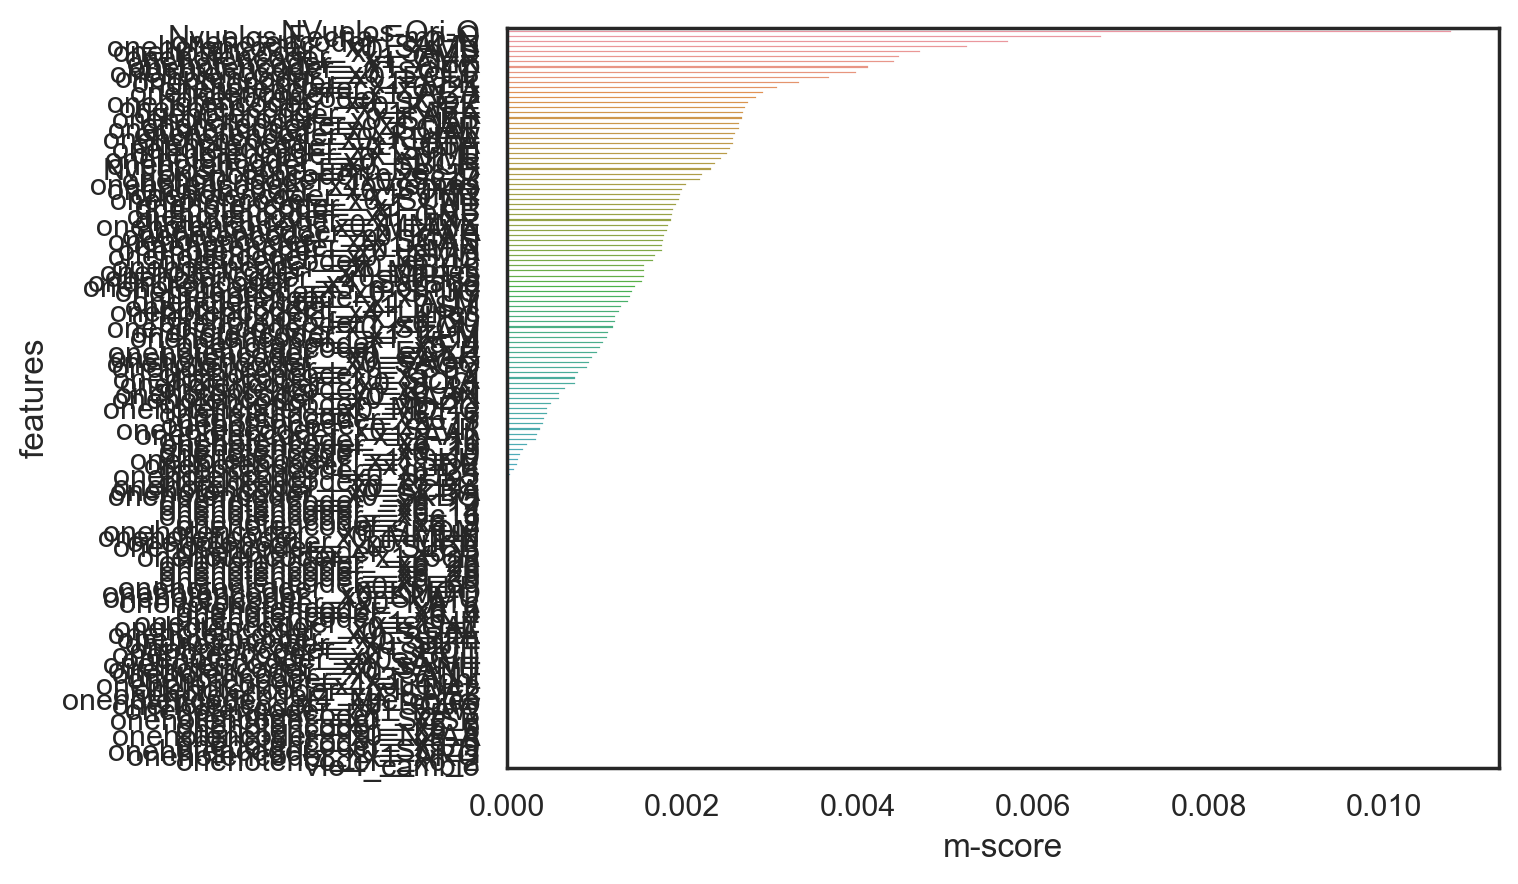

In [4]:
%%time
selected_features=variable_selection(X_train,y_train)
sns.barplot(x='m-score', y='features', data=selected_features);

In [15]:
selected_features.sort_values(by='m-score',ascending=False).head(80)

,features,m-score,m-weight,ranking_ffe_rf,ranking_ffe_rl,ranking_ffe_gb
0,NVuelos-Ori-O,0.010768,1.000000,1,7,28
1,Nvuelos-Fecha-Emp-O,0.006782,0.629851,2,75,74
2,onehotencoder__x2_N,0.005720,0.531200,4,138,40
3,onehotencoder__x0_SAME,0.005253,0.487782,38,39,69
4,onehotencoder__x0_SAZS,0.004721,0.438412,137,41,145
...,...,...,...,...,...,...
75,onehotencoder__x6_16,0.000474,0.044043,53,86,25
76,onehotencoder__x6_7,0.000439,0.040774,90,67,35
77,onehotencoder__x5_11,0.000426,0.039564,44,89,87
78,onehotencoder__x0_SLVR,0.000390,0.036194,127,42,113


### Training the models